In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import json
from tqdm.notebook import tqdm
import re

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly

import sklearn
from sklearn.decomposition import PCA, FastICA
from sklearn.manifold import TSNE, Isomap

from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import LabelEncoder
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import (KMeans, SpectralClustering, 
                             MiniBatchKMeans, AgglomerativeClustering)

from sklearn.metrics import (davies_bouldin_score, 
                            silhouette_score,
                            calinski_harabasz_score,
                            homogeneity_score)


In [2]:
with open('config/config.json', 'r') as file:
    config = json.load(file)
    
    
rs = config['random_state']

# Loading Data

In [3]:
df = pd.read_csv(config['ticker_data_preprocessed'], index_col=0)
df_index = pd.read_csv(config['ticker_data_sp500'], index_col=0)
df_sectors = pd.read_csv(config['tickers_sectors_path'], index_col=0)
print(df.shape)
df.head()

(482, 1152)


2018-01-03  2018-01-04  2018-01-05  2018-01-08  2018-01-09  2018-01-10  \
A       0.025444   -0.007501    0.015988    0.002146    0.024554   -0.013655   
AAL    -0.012266    0.006305   -0.000380   -0.009877   -0.000959    0.032642   
AAP     0.009049    0.036899    0.010631   -0.007042   -0.008080    0.000905   
AAPL   -0.000174    0.004645    0.011385   -0.003714   -0.000115   -0.000229   
ABBV    0.015649   -0.005703    0.017408   -0.016022    0.007538   -0.005487   

      2018-01-11  2018-01-12  2018-01-16  2018-01-17  ...  2022-07-19  \
A       0.000141    0.013136   -0.006971    0.011652  ...    0.034315   
AAL     0.049089    0.036335   -0.008380    0.003105  ...    0.042641   
AAP     0.021340    0.026472   -0.017595    0.012730  ...    0.029039   
AAPL    0.005680    0.010326   -0.005082    0.016516  ...    0.026722   
ABBV   -0.004213    0.010779    0.021427    0.018246  ...    0.001137   

      2022-07-20  2022-07-21  2022-07-22  2022-07-25  2022-07-26  2022-07-27  \
A       0.006719    0.061155   -0.016904   -0.006238         0.0         0.0   
AAL     0.003298   -0.074293   -0.028409    0.005117         0.0         0.0   
AAP     0.010543   -0.014689    0.007375   -0.008367         0.0         0.0   
AAPL    0.013510    0.015094   -0.008111   -0.007398         0.0         0.0   
ABBV   -0.013690    0.000406    0.004873    0.011787         0.0         0.0   

      2022-07-28  2022-07-29             sector  
A            0.0         0.0         Healthcare  
AAL          0.0         0.0        Industrials  
AAP          0.0         0.0  Consumer Cyclical  
AAPL         0.0         0.0         Technology  
ABBV         0.0         0.0         Healthcare  

[5 rows x 1152 columns]

In [4]:
tickers = df.index.tolist()

In [5]:
feats_tsne = TSNE(n_components=2).fit_transform(df.drop(['sector'], axis=1))
df_tsne = pd.DataFrame({'axis0':feats_tsne[:, 0],'axis1':feats_tsne[:, 1],'sector':df['sector']})

fig = px.scatter(df_tsne, x = 'axis0', y = 'axis1', color="sector", width=800, height=600)
fig.show()

# Preprocessing

In [6]:
dict_features = dict()

## decompositions

In [7]:
feats_pca = PCA(n_components=18, random_state=rs).fit_transform(df.drop(['sector'], axis=1))
dict_features['decomp;pca;n_components:18'] = feats_pca

feats_fica = FastICA(n_components=18, random_state=rs).fit_transform(df.drop(['sector'], axis=1))
dict_features['decomp;fast_ica;n_components:18'] = feats_fica

feats_iso = Isomap(n_components=18).fit_transform(df.drop(['sector'], axis=1))
dict_features['decomp;isomap;n_components:18'] = feats_iso

## table data

In [8]:
table_features = pd.read_csv(config['features_path'], index_col=0)

table_features = StandardScaler().fit_transform(table_features)
dict_features['table_data;;'] = table_features

## neural network

In [9]:
tickers = df.index.tolist()

df_conv = pd.read_csv(config['nn_conv_data'], index_col=0).loc[tickers]
df_mlp = pd.read_csv(config['nn_mlp_data'], index_col=0).loc[tickers]
df_lstm = pd.read_csv(config['nn_lstm_data'], index_col=0).loc[tickers]

dict_features['neural;conv;window:30'] = df_conv
dict_features['neural;mlp;window:30'] = df_mlp
dict_features['neural;lstm;window:100'] = df_lstm

## original

In [10]:
dict_features['original;;'] = df.drop(['sector'], axis=1).values

# Clustering

In [11]:
def score_func(estimator, X, y):
    labels_predicted = estimator.fit_predict(X)
    score = silhouette_score(X, labels_predicted)
    return score

def gridsearch(model, X, y, parameters:dict):
    custom_cv=[(slice(None), slice(None))]
    grid_search = GridSearchCV(model, param_grid=parameters, scoring=score_func, cv=custom_cv)
    grid_search.fit(X, y)
    labels_predicted = grid_search.best_estimator_.fit_predict(X)
    return grid_search.best_params_, labels_predicted

def parse_dict(best_params_dict, model_name, preproc_label):
    name = preproc_label + '|' + model_name + ';'
    for key, value in best_params_dict.items():
        name = name + key + ':' + str(value) + ','
    return name[:-1]
    

def train_all(models_dict, params_dict, preproc_label, X, y=None, grid_search=True, n_clusters_=config['n_clusters']):
    output = {}
    for model_name, model in models_dict.items():
        print(model_name)
        param_grid = params_dict[model_name]
        
        if grid_search:
            best_params_dict, labels_predicted = gridsearch(model, X, y, param_grid)
            final_key = parse_dict(best_params_dict, model_name, preproc_label)
        else:
            if model_name == 'Gauss_Mix': 
                model=model(n_components=n_clusters_)
            else:
                model=model(n_clusters=n_clusters_)
                
            model_loc = model.fit(X)
            labels_predicted = model_loc.labels_
            final_key = preproc_label + '|' + 'original'

        
        output[final_key] = labels_predicted
        print('done')
    return output



In [12]:
models_dict = {'Kmeans': KMeans(random_state=rs),
               'Agglomer': AgglomerativeClustering(),
               'MiniBatchKMeans': MiniBatchKMeans(random_state=rs),
               'Gauss_Mix': GaussianMixture(random_state=rs),
               'Spectral': SpectralClustering(random_state=rs)}

n_clusters = np.arange(9, 14)

params_dict = {'Kmeans': 
               {
                   'n_clusters':n_clusters,
                   'init': ['k-means++', 'random'],
                   'algorithm':['auto', 'full', 'elkan']
               },
               
               'Agglomer': 
               {
                   'n_clusters': n_clusters,
                   'linkage': ['ward', 'complete', 'average', 'single'],
               },
               'MiniBatchKMeans':
               {
                   'n_clusters': n_clusters,
                   'init':['k-means++', 'random'],
               },
               'Gauss_Mix': 
               {
                   'n_components': n_clusters,
                   'covariance_type':['full', 'tied', 'diag', 'spherical'],
                   'init_params': ['kmeans', 'random']
               },
               'Spectral': 
               {
                   'n_clusters': n_clusters,
                   'eigen_solver':['arpack', 'lobpcg'],
               }
              }

In [13]:
n_clusters_ = df_sectors['sector'].nunique()

df_predictions = pd.DataFrame(df['sector'].values, index=df.index, columns=['original'])
df_predictions['original_n'] = LabelEncoder().fit_transform(df_predictions['original'])
df_predictions.head()

original  original_n
A            Healthcare           6
AAL         Industrials           7
AAP   Consumer Cyclical           2
AAPL         Technology           9
ABBV         Healthcare           6

In [14]:

for prepr_name, data in dict_features.items():
    print(f"--------------------- {prepr_name} ---------------------")
    X = data
    y = df['sector'].values
    gridsearch_output = train_all(models_dict, params_dict, preproc_label=prepr_name, X=X, y=y)
    prepr_predictions = pd.DataFrame(gridsearch_output, index=df_predictions.index)
    
    df_predictions = pd.concat([df_predictions, prepr_predictions], axis=1)
    print()

--------------------- decomp;pca;n_components:18 ---------------------
Kmeans
done
Agglomer
done
MiniBatchKMeans
done
Gauss_Mix
done
Spectral
done

--------------------- decomp;fast_ica;n_components:18 ---------------------
Kmeans
done
Agglomer
done
MiniBatchKMeans
done
Gauss_Mix
done
Spectral
done

--------------------- decomp;isomap;n_components:18 ---------------------
Kmeans
done
Agglomer
done
MiniBatchKMeans
done
Gauss_Mix
done
Spectral
done

--------------------- table_data;; ---------------------
Kmeans
done
Agglomer
done
MiniBatchKMeans
done
Gauss_Mix
done
Spectral
done

--------------------- neural;conv;window:30 ---------------------
Kmeans
done
Agglomer
done
MiniBatchKMeans
done
Gauss_Mix
done
Spectral
done

--------------------- neural;mlp;window:30 ---------------------
Kmeans
done
Agglomer
done
MiniBatchKMeans
done
Gauss_Mix
done
Spectral
done

--------------------- neural;lstm;window:100 ---------------------
Kmeans
done
Agglomer
done
MiniBatchKMeans
done
Gauss_Mix
done


In [15]:
df_predictions['original;;|original;'] = df_predictions['original_n']

In [16]:
model_name = f'original;;|random;random_state:{rs}'

X = df.drop(['sector'], axis=1).values

np.random.seed(rs)
clust_pred = np.random.choice(df_predictions['original;;|original;'].unique(), size=len(df))
df_predictions[model_name] = clust_pred

# Calculating metrics

In [17]:
def renaming(name):
    data_name, model_name = name.split('|')
    model_name = model_name[:5]
    data_name, data_surname, params = data_name.split(';')
    new_name = data_name[:4] + '_' + data_surname[:4] + '_' + model_name
    return new_name

def get_n_clusters(text):
    n_clusters = re.findall(r'(n_clusters:|n_components:)(\d+)', text)

    if len(n_clusters) == 0:
        return np.nan
    n_clusters = int(n_clusters[0][1])
    return n_clusters

In [18]:
metrics = {'silhouette':silhouette_score, 
           'davies_bouldin':davies_bouldin_score, 
           'calinski_harabasz':calinski_harabasz_score, 
           'homogeneity':homogeneity_score}


metrics_df = pd.DataFrame(columns = list(metrics.keys()))
dict_features['original;;'] = df.drop(['sector'], axis=1).values

for features_model in df_predictions.columns[2:]:
    if features_model == 'neural;lstm;window:100|Gauss_Mix;covariance_type:full,init_params:kmeans,n_components:9':
        continue
        
    features_model
    metrics_list = []
    for metric_name, metric_formula in metrics.items():
        
        if metric_name == 'homogeneity':
            metric_meaning = metric_formula(df_predictions['original'], df_predictions[features_model])
        else:
            features = features_model.split('|')[0]

            
            metric_meaning = metric_formula(dict_features[features], df_predictions[features_model])
        metrics_list.append(metric_meaning)
    metrics_df.loc[features_model] = metrics_list

    
model_params = metrics_df.index.tolist()
metrics_df.index = metrics_df.reset_index()['index'].apply(lambda x: renaming(x))
model_short_names = metrics_df.index.tolist()

In [19]:
df_params = pd.DataFrame({'short_name': model_short_names, 
                         'all_params': model_params})
df_params['model'] = df_params['all_params'].apply(lambda x: x.split('|')[1].split(';')[0])
df_params['f_name'] = df_params['all_params'].apply(lambda x: x.split('|')[0].split(';')[0])
df_params['f_surname'] = df_params['all_params'].apply(lambda x: x.split('|')[0].split(';')[1])
df_params['f_full_name'] = df_params['f_name'] + '_' + df_params['f_surname']
df_params['n_clusters'] = df_params['all_params'].apply(lambda x: get_n_clusters(x))
df_params.head()

short_name                                         all_params  \
0  deco_pca_Kmean  decomp;pca;n_components:18|Kmeans;algorithm:au...   
1  deco_pca_Agglo  decomp;pca;n_components:18|Agglomer;linkage:av...   
2  deco_pca_MiniB  decomp;pca;n_components:18|MiniBatchKMeans;ini...   
3  deco_pca_Gauss  decomp;pca;n_components:18|Gauss_Mix;covarianc...   
4  deco_pca_Spect  decomp;pca;n_components:18|Spectral;eigen_solv...   

             model  f_name f_surname f_full_name  n_clusters  
0           Kmeans  decomp       pca  decomp_pca        18.0  
1         Agglomer  decomp       pca  decomp_pca        18.0  
2  MiniBatchKMeans  decomp       pca  decomp_pca        18.0  
3        Gauss_Mix  decomp       pca  decomp_pca        18.0  
4         Spectral  decomp       pca  decomp_pca        18.0

In [20]:
new_col_names = []
for col in df_predictions.columns:
    if len(col.split('|')) == 2:
        col = renaming(col)
    new_col_names.append(col)
    
df_predictions.columns = new_col_names
df_predictions.head()

original  original_n  deco_pca_Kmean  deco_pca_Agglo  \
A            Healthcare           6               2               0   
AAL         Industrials           7               6               2   
AAP   Consumer Cyclical           2               1               0   
AAPL         Technology           9               2               0   
ABBV         Healthcare           6               8               0   

      deco_pca_MiniB  deco_pca_Gauss  deco_pca_Spect  deco_fast_Kmean  \
A                  5               0               9                6   
AAL                2               9               3                2   
AAP                6               5               1                5   
AAPL               5               2               9                0   
ABBV               6               0               1                6   

      deco_fast_Agglo  deco_fast_MiniB  ...  neur_lstm_MiniB  neur_lstm_Gauss  \
A                   0                5  ...                3                0   
AAL                 0                9  ...                4                0   
AAP                 0                1  ...                8                0   
AAPL                0                7  ...                3                0   
ABBV                0                5  ...                6                0   

      neur_lstm_Spect  orig__Kmean  orig__Agglo  orig__MiniB  orig__Gauss  \
A                   0            6            0            2            4   
AAL                 0            0            0            9            7   
AAP                 7            6            0           10            3   
AAPL                7            1            0            5            4   
ABBV                7            6            0            2            4   

      orig__Spect  orig__origi  orig__rando  
A               9            6            5  
AAL             8            7            9  
AAP             7            2            1  
AAPL            9            9            0  
ABBV            7            6            3  

[5 rows x 44 columns]

In [21]:
def rank_methods(df):
    
    for c in df.columns:
        if c == 'davies_bouldin':
            df[c] = df[c].rank(method='dense',ascending=True).astype(int)
        else:
            df[c] = df[c].rank(method='dense',ascending=False).astype(int)
            
    return df.mean(axis=1)

def choose_method(df_mean_ranked):
    method = df_mean_ranked.argmin()
    return method


metrics_df = metrics_df.sort_values(by=['silhouette'], ascending=False)
metrics_df.head()

silhouette  davies_bouldin  calinski_harabasz  homogeneity
index                                                                      
neur_mlp_Agglo     0.597165        0.353913          23.546963     0.017588
deco_fast_Agglo    0.418209        0.330518          11.784718     0.016576
tabl__Agglo        0.371994        0.391809          13.825907     0.020517
tabl__Spect        0.364458        0.737469          22.403525     0.032427
deco_pca_Agglo     0.343843        0.732602          23.664186     0.100128

In [22]:
metrics_df = metrics_df.reset_index().rename({'index':'short_name'}, axis=1)
metrics_params_df = metrics_df.merge(df_params, on='short_name')
metrics_params_df.head()

short_name  silhouette  davies_bouldin  calinski_harabasz  \
0   neur_mlp_Agglo    0.597165        0.353913          23.546963   
1  deco_fast_Agglo    0.418209        0.330518          11.784718   
2      tabl__Agglo    0.371994        0.391809          13.825907   
3      tabl__Spect    0.364458        0.737469          22.403525   
4   deco_pca_Agglo    0.343843        0.732602          23.664186   

   homogeneity                                         all_params     model  \
0     0.017588  neural;mlp;window:30|Agglomer;linkage:single,n...  Agglomer   
1     0.016576  decomp;fast_ica;n_components:18|Agglomer;linka...  Agglomer   
2     0.020517  table_data;;|Agglomer;linkage:single,n_clusters:9  Agglomer   
3     0.032427  table_data;;|Spectral;eigen_solver:lobpcg,n_cl...  Spectral   
4     0.100128  decomp;pca;n_components:18|Agglomer;linkage:av...  Agglomer   

       f_name f_surname      f_full_name  n_clusters  
0      neural       mlp       neural_mlp         9.0  
1      decomp  fast_ica  decomp_fast_ica        18.0  
2  table_data                table_data_         9.0  
3  table_data                table_data_         9.0  
4      decomp       pca       decomp_pca        18.0

In [23]:
mean_rnk_cl_data = dict()
pd_best_clust_model = pd.DataFrame()
best_methods = []

for preproc in df_params['f_full_name'].unique():
    
    metrics_params_df_loc = metrics_params_df[(metrics_params_df['f_full_name'] == preproc)&
                                         (metrics_params_df['short_name'] != 'orig__rando')&
                                         (metrics_params_df['short_name'] != 'orig__origi')]
    
    metrics_rank = metrics_params_df_loc[['silhouette', 'davies_bouldin', 'calinski_harabasz','homogeneity']]
    df_mean_ranked = rank_methods(metrics_rank.copy())
    rank_dict = dict(zip(metrics_params_df_loc['short_name'].values.tolist() , df_mean_ranked.values.tolist()))
    mean_rnk_cl_data.update(rank_dict)
    
    best_method = metrics_params_df_loc['short_name'].iloc[np.argmin(df_mean_ranked)]

    
    best_methods.append(best_method)
    
mean_rnk_cl_data['orig__rando'] = np.nan
mean_rnk_cl_data['orig__origi'] = np.nan

In [24]:
metrics_params_df['mean_rnk_cl_data'] = metrics_params_df['short_name'].map(mean_rnk_cl_data)
metrics_params_df.head()

short_name  silhouette  davies_bouldin  calinski_harabasz  \
0   neur_mlp_Agglo    0.597165        0.353913          23.546963   
1  deco_fast_Agglo    0.418209        0.330518          11.784718   
2      tabl__Agglo    0.371994        0.391809          13.825907   
3      tabl__Spect    0.364458        0.737469          22.403525   
4   deco_pca_Agglo    0.343843        0.732602          23.664186   

   homogeneity                                         all_params     model  \
0     0.017588  neural;mlp;window:30|Agglomer;linkage:single,n...  Agglomer   
1     0.016576  decomp;fast_ica;n_components:18|Agglomer;linka...  Agglomer   
2     0.020517  table_data;;|Agglomer;linkage:single,n_clusters:9  Agglomer   
3     0.032427  table_data;;|Spectral;eigen_solver:lobpcg,n_cl...  Spectral   
4     0.100128  decomp;pca;n_components:18|Agglomer;linkage:av...  Agglomer   

       f_name f_surname      f_full_name  n_clusters  mean_rnk_cl_data  
0      neural       mlp       neural_mlp         9.0               3.0  
1      decomp  fast_ica  decomp_fast_ica        18.0               3.0  
2  table_data                table_data_         9.0               3.0  
3  table_data                table_data_         9.0               3.0  
4      decomp       pca       decomp_pca        18.0               3.0

In [25]:
metrics_best = metrics_params_df.query('short_name in @best_methods')
metrics_best

short_name  silhouette  davies_bouldin  calinski_harabasz  \
5   neur_lstm_Kmean    0.333551        0.868761         401.786056   
11  deco_isom_Agglo    0.240994        1.335024          92.058292   
14      tabl__Kmean    0.219194        1.137326         128.041560   
19   deco_pca_Kmean    0.170102        1.536149          71.022143   
22  deco_fast_Kmean    0.156806        1.499384          32.043208   
30   neur_mlp_Kmean    0.130992        1.874386         162.632115   
31  neur_conv_MiniB    0.097568        1.833193          42.098251   
34      orig__Spect    0.041580        2.638672          16.080998   

    homogeneity                                         all_params  \
5      0.110597  neural;lstm;window:100|Kmeans;algorithm:auto,i...   
11     0.486379  decomp;isomap;n_components:18|Agglomer;linkage...   
14     0.136483  table_data;;|Kmeans;algorithm:auto,init:k-mean...   
19     0.302917  decomp;pca;n_components:18|Kmeans;algorithm:au...   
22     0.594091  decomp;fast_ica;n_components:18|Kmeans;algorit...   
30     0.132303  neural;mlp;window:30|Kmeans;algorithm:auto,ini...   
31     0.180234  neural;conv;window:30|MiniBatchKMeans;init:k-m...   
34     0.444493  original;;|Spectral;eigen_solver:lobpcg,n_clus...   

              model      f_name f_surname      f_full_name  n_clusters  \
5            Kmeans      neural      lstm      neural_lstm         9.0   
11         Agglomer      decomp    isomap    decomp_isomap        18.0   
14           Kmeans  table_data                table_data_         9.0   
19           Kmeans      decomp       pca       decomp_pca        18.0   
22           Kmeans      decomp  fast_ica  decomp_fast_ica        18.0   
30           Kmeans      neural       mlp       neural_mlp         9.0   
31  MiniBatchKMeans      neural      conv      neural_conv        10.0   
34         Spectral    original                  original_        12.0   

    mean_rnk_cl_data  
5               1.75  
11              1.75  
14              2.25  
19              2.50  
22              1.50  
30              2.50  
31              2.25  
34              2.25

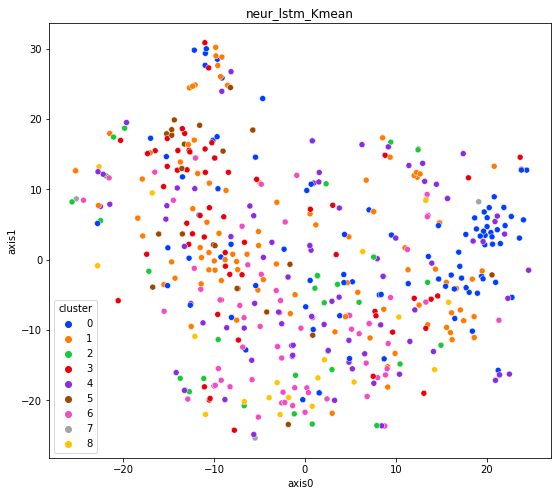

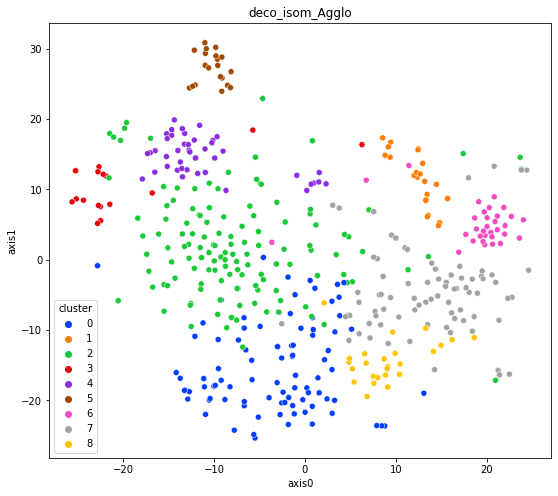

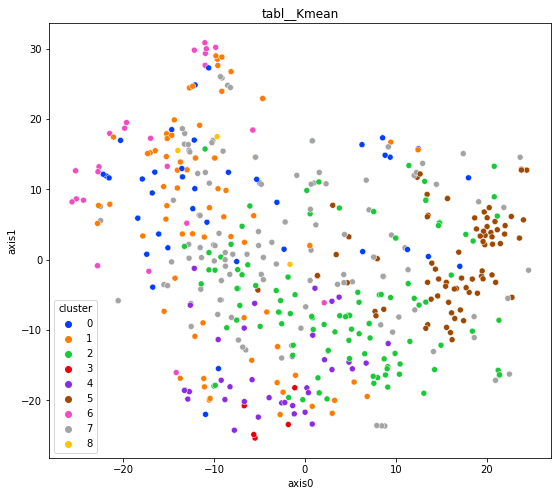

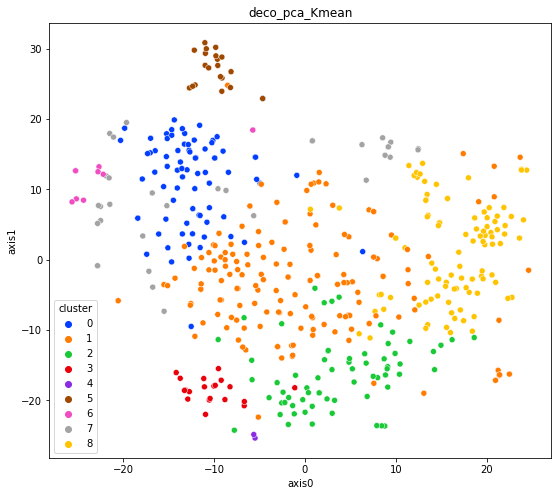

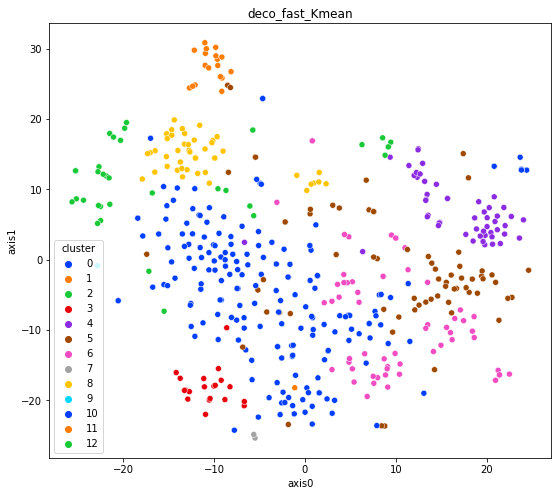

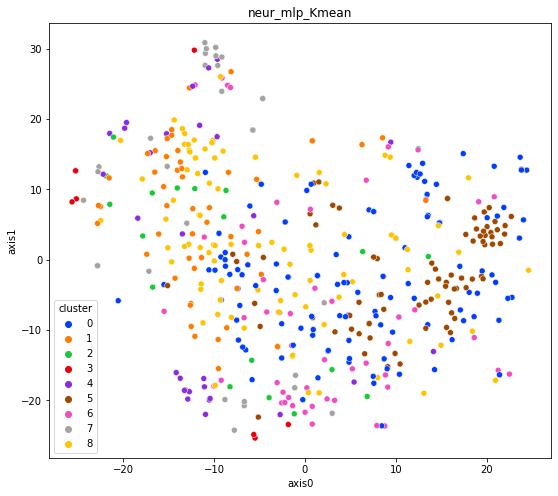

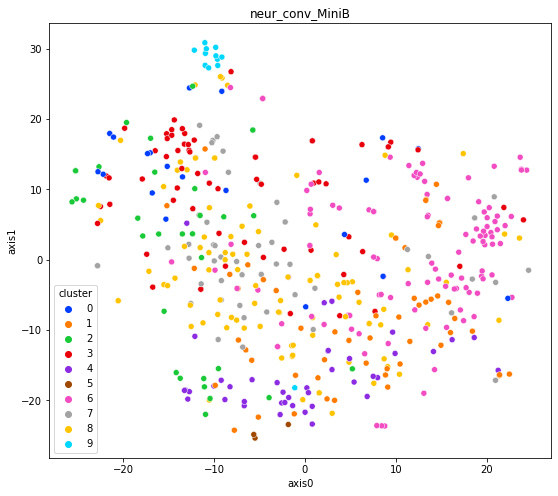

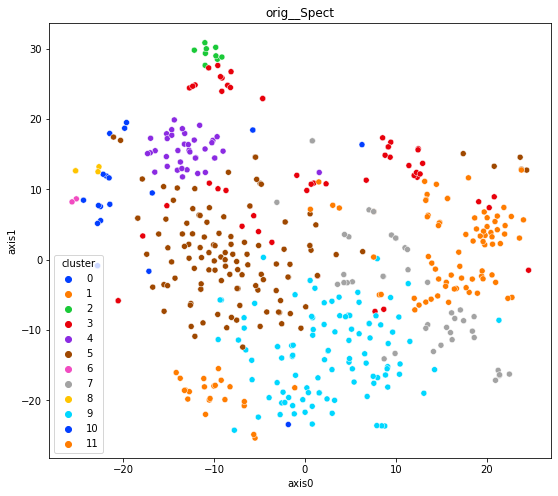

In [26]:
feats_tsne = TSNE(n_components=2).fit_transform(df.drop(['sector'], axis=1))
for method in metrics_best['short_name']:
    
    clusters = df_predictions[method]
    df_tsne = pd.DataFrame({'axis0':feats_tsne[:, 0],'axis1':feats_tsne[:, 1],'cluster':clusters})
    plt.figure(figsize=(9, 8))
    sns.scatterplot(x=df_tsne['axis0'], y=df_tsne['axis1'], hue=df_tsne['cluster'], palette='bright')
    plt.title(method)
    plt.show()

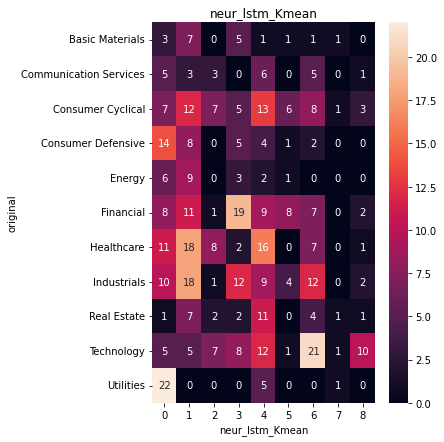

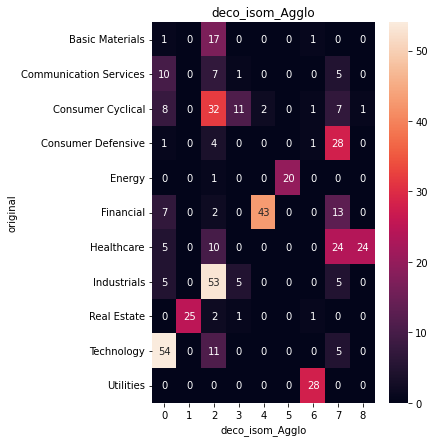

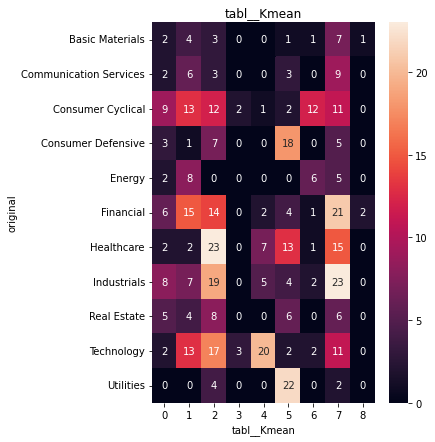

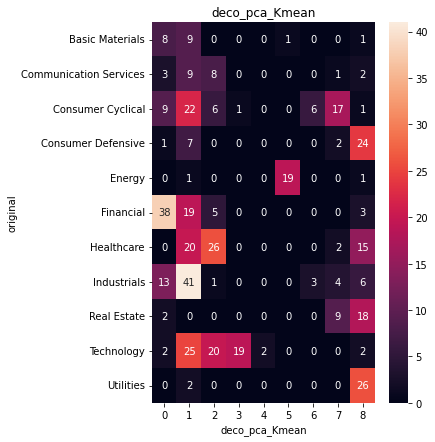

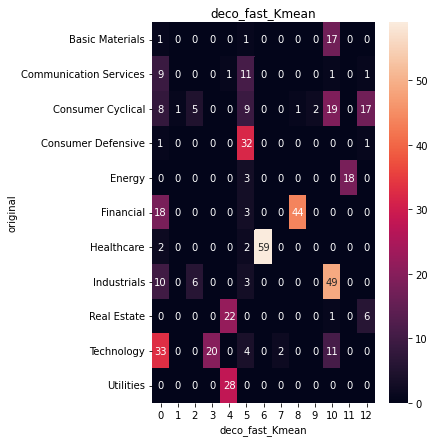

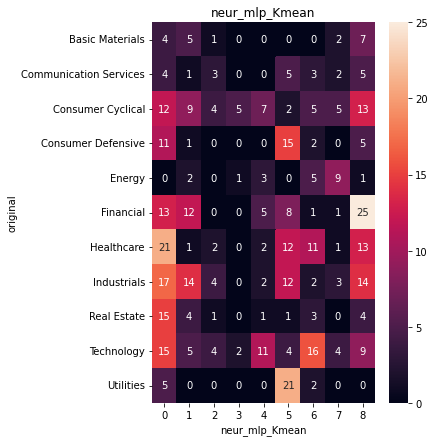

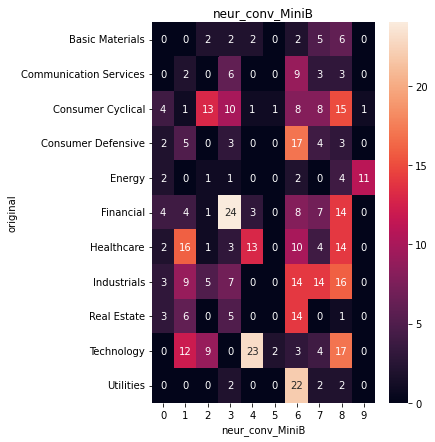

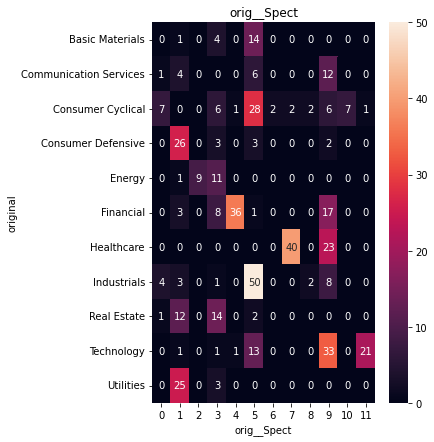

In [27]:
for method in metrics_best['short_name']:
    
    df_crosstab = pd.crosstab(df_predictions['original'], df_predictions[method])
    plt.figure(figsize=(5, 7))
    sns.heatmap(df_crosstab, annot=True)
    plt.title(method)
    plt.show()

# Saving results

In [28]:
metrics_df.to_csv(config['metrics_path'])
df_predictions.to_csv(config['predictions_path'])
df_params.to_csv(config['params_path'])
metrics_best.drop(['all_params'], axis=1).to_csv(config['best_metrics_path'])